# ABCD Function

In [44]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [45]:
def ABCD(p,PE,par):
    
    """
    This function simulate streamflow by ABCD model(Thomas 1981) . the inputs are 
    p:precipitation
    
    par: [a,b,c,d,S0,G0] model parameters
    a:Propensity of runoff to occur before soil is saturated
    b:Maximum daily water consumption 
    c:Baseflow index, or the ratio of baseflow to total runoff
    d:Reciprocal of groundwater residence time
    S0:initial soil moisture
    G0:initial ground water storage
    PE:ptential evapotranspiration
    
    
    """
    
    
    a=par[0]
    b=par[1]
    c=par[2]
    d=par[3]
    W=np.zeros(len(p))
    Y=np.zeros(len(p))
    Q=np.zeros(len(p))
    S=np.zeros(len(p))
    G=np.zeros(len(p))
    E=np.zeros(len(p))
    GR=np.zeros(len(p))
    DR=np.zeros(len(p))
    
    S[0]=10
    G[0]=10


    for t in range(1,len(p)):
        W[t]=p[t]+S[t-1]
        Y[t]=(W[t]+b)/(2*a)-np.sqrt((0.5*(W[t]+b)/a)**2-(b*W[t]/a))
        S[t]=Y[t]*np.exp(-PE[t]/b)
        GR[t]=c*(W[t]-Y[t])
        DR[t]=(1-c)*(W[t]-Y[t])
        G[t]=(c*(W[t]-Y[t])+G[t-1])/(1+d)
        Q[t]=(1-c)*(W[t]-Y[t])+d*G[t]
    
    return Q,Y,G,S

In [46]:
def PET(phi,J,Tmax,Tmin):
    """
    calculate potential evapotranspiration by Shuttleworth(1993)
    inputs:
    J=julian day
    phi=latitude in radian
    Tmax & Tmin= max and min temprature

    """
    dr=1+0.033*np.cos(2*np.pi/365*J)
    delta=0.4093*np.sin(2*np.pi/365*J-1.405)
    omega=np.arccos(-1*np.tan(phi)*np.tan(delta))
    
    SR=0.6059*dr*(omega*np.sin(dr)*np.sin(delta)+np.cos(phi)*np.cos(delta)*np.sin(omega))
    Tave=(Tmax+Tmin)/2
    pe=0.0023*SR*(Tmax-Tmin)**0.5*(Tave+17.8)
    return pe

In [47]:
def e_fun(emax,emin,j):
    e=(emax+emin)/2+np.sin(2*math.pi*j/365)*((emax+emin)/2)
    return e



def SnowMelt(P,T,emin,emax,j,Tb,Tbm):
    
    Pe=np.ones(len(P))
    A=np.zeros(len(P))
    M=np.zeros(len(P))
    for t in range(1,(len(P))):
        e=(emax+emin)/2+np.sin(2*math.pi*j[t]/365)*((emax+emin)/2)
        if T[t]< Tb:
            Pe[t]=precip[t]
            A[t]=A[t-1]-M[t-1]+P[t]
        if T[t]>= Tb:
            M[t]=min(A[t-1],e*(T[t]-Tbm))
            Pe[t]=P[t]+M[t]
            A[t]=A[t-1]-M[t]
    return Pe

def snowMelt_cons_e(P,T,e,j,Tb,Tbm):
    
    Pe=np.ones(len(P))
    A=np.zeros(len(P))
    M=np.zeros(len(P))
    for t in range(1,(len(P))):
        
        if T[t]< Tb:
            Pe[t]=precip[t]
            A[t]=A[t-1]-M[t-1]+P[t]
        if T[t]>= Tb:
            M[t]=min(A[t-1],e*(T[t]-Tbm))
            Pe[t]=P[t]+M[t]
            A[t]=A[t-1]-M[t]
    return Pe

In [48]:
def NSE(Qs,Qobs):
    ''''
    The Nash–Sutcliffe model efficiency coefficient (NSE) is used to assess the predictive power of hydrological models
    Nash–Sutcliffe efficiency can range from −∞ to 1. An efficiency of 1 (NSE = 1) corresponds to a perfect match of modeled discharge to the observed data.
    An efficiency of 0 (NSE = 0) indicates that the model predictions are as accurate as the mean of the observed data,
    whereas an efficiency less than zero (NSE < 0) occurs when the observed mean is a better predictor than the model
    Qs: simulated flow
    Qobs: observed flow
    '''
    MSE= np.mean((Qs-Qobs)**2)
    NSE=1-MSE/np.var(Qobs,ddof=1)
    return NSE

In [49]:
def LBE(S,O,prime=False):
    mu_O,var_O,mu_S,var_S,rho = BLN3_moments(O,S)
    
    Co = np.sqrt(var_O)/mu_O#Eq. 18
    alpha = np.sqrt(var_S)/np.sqrt(var_O)
    delta = 1.-mu_S/mu_O
    beta = 1.-delta

    if prime == False:
        LBE_hat = 2.*alpha*rho-alpha**2.-(delta**2)/(Co**2) #Lamontagne et al. (2020) eq. 18a
    elif prime == True:
        LBE_hat = 1.-np.sqrt((beta-1.)**2.+(alpha-1.)**2.+(rho-1.)**2.) #Lamontagne et al. (2020) eq. 18b
    return LBE_hat
def BLN3_moments(O,S):
    U,tau_O = LN3_trans(O)
    V,tau_S = LN3_trans(S)
    
    U_bar = np.mean(U)
    V_bar = np.mean(V)
    var_U = np.var(U,ddof=1)
    var_V = np.var(V,ddof=1)
    cov_UV = np.cov(U,V,rowvar=False,ddof=None)[0,1]
    
    mu_O = tau_O+np.exp(U_bar+var_U/2.)
    mu_S = tau_S+np.exp(V_bar+var_V/2.)
    var_O = np.exp(2.*U_bar+var_U)*(np.exp(var_U)-1.)
    var_S = np.exp(2.*V_bar+var_V)*(np.exp(var_V)-1.)
    
    rho = (np.exp(cov_UV)-1.)/np.sqrt((np.exp(var_U)-1.)*(np.exp(var_V)-1.))
    return mu_O,var_O,mu_S,var_S,rho

def stedinger_tau(X):
    if X.min()+X.max()-2.*np.median(X)>0:
        tau = (X.min()*X.max()-np.median(X)**2)/(X.min()+X.max()-2.*np.median(X))
    else:
        tau = 0.
    return tau

def LN3_trans(X):
    tau = stedinger_tau(X)
    Y = np.log(X-tau)
    return Y,tau

In [50]:
# period: a vector with the lenght of S and O
def LBEm(S,O,period,prime=False):
    
    mu_Om,mu_Sm,var_Om,var_Sm,mu_SOm = mixture_moments(S,O,period,prime=False)
    alpha_m = np.sqrt(var_Sm)/np.sqrt(var_Om)#Lamontagne et al. 2020 eqn. 20
    delta_m = 1.-mu_Sm/mu_Om
    Co_m = np.sqrt(var_Om)/mu_Om
    r_m = (mu_SOm-mu_Om*mu_Sm)/(np.sqrt(var_Om)*np.sqrt(var_Sm))
    
    if prime == False:
        LBEm_hat = 2*alpha_m*r_m-alpha_m**2-(delta_m**2)/(Co_m**2)#Lamontagne et al. 2020 eqn. 20a
    elif prime == True:
        LBEm_hat = 1-np.sqrt((delta_m**2)+(alpha_m-1)**2+(r_m-1)**2)#Lamontagne et al. 2020 eqn. 20b
    return LBEm_hat


def mixture_moments(S,O,period,prime=False):
    m = np.size(np.unique(period))
    mu_O = np.zeros([m,1])
    var_O = np.zeros([m,1])
    mu_S = np.zeros([m,1])
    var_S = np.zeros([m,1])
    rho = np.zeros([m,1])
    
    for i in range(m):
        mu_O[i],var_O[i],mu_S[i],var_S[i],rho[i] = BLN3_moments(O[period==i],S[period==i])
    mu_O_hat = np.mean(mu_O)
    mu_S_hat = np.mean(mu_S)
    
    var_O_hat = np.mean(var_O+mu_O**2)-mu_O_hat**2
    var_S_hat = np.mean(var_S+mu_S**2)-mu_S_hat**2
    
    mu_SO_hat = np.mean(mu_S*mu_O+rho*np.sqrt(var_S)*np.sqrt(var_O))
    return mu_O_hat,mu_S_hat,var_O_hat,var_S_hat,mu_SO_hat

def BLN3_moments(O,S):
    U,tau_O = LN3_trans(O)
    V,tau_S = LN3_trans(S)
    
    U_bar = np.mean(U)
    V_bar = np.mean(V)
    var_U = np.var(U,ddof=1)
    var_V = np.var(V,ddof=1)
    cov_UV = np.cov(U,V,rowvar=False,ddof=None)[0,1]
    
    mu_O = tau_O+np.exp(U_bar+var_U/2.)
    mu_S = tau_S+np.exp(V_bar+var_V/2.)
    var_O = np.exp(2.*U_bar+var_U)*(np.exp(var_U)-1.)
    var_S = np.exp(2.*V_bar+var_V)*(np.exp(var_V)-1.)
    
    rho = (np.exp(cov_UV)-1.)/np.sqrt((np.exp(var_U)-1.)*(np.exp(var_V)-1.))
    return mu_O,var_O,mu_S,var_S,rho

def stedinger_tau(X):
    if X.min()+X.max()-2.*np.median(X)>0:
        tau = (X.min()*X.max()-np.median(X)**2)/(X.min()+X.max()-2.*np.median(X))
    else:
        tau = 0.
    return tau

def LN3_trans(X):
    tau = stedinger_tau(X)
    Y = np.log(X-tau)
    return Y,tau

# Importing gage data 

In [61]:
PRISM=pd.read_csv('PRISM_medway.csv',parse_dates=['Date'],index_col='Date')
ppt=PRISM['ppt (inches)']
PRISM.head()

,ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F)
Date,,,,
1997-11-12,0.00,23.4,37.7,52.0
1997-11-13,0.00,23.2,34.1,44.9
1997-11-14,0.21,25.3,33.9,42.5
1997-11-15,1.32,26.1,31.2,36.3
1997-11-16,0.00,25.5,31.6,37.8


In [62]:
Q_obs=pd.read_excel('gage01103280.xlsx',parse_dates=True,index_col='date')
Q_obs.head()

,Discharge[ft3/s]
date,
1997-11-12,59.0
1997-11-13,49.0
1997-11-14,44.0
1997-11-15,41.0
1997-11-16,40.0


In [64]:
Q_P = Q_obs.join(PRISM)
Q_P=Q_P.dropna()
Area=1.8316e+9
Q_P['Qobs']=Q_P['Discharge[ft3/s]']/Area*1.037e+6

Precip=np.array(Q_P['ppt (inches)'].values.tolist())
#Q_P = Q_P[Q_P['delta'] >= 0]
#Q_P['ppt']=ppt
Q_P.head()

,Discharge[ft3/s],ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),Qobs
date,,,,,,
1997-11-12,59.0,0.00,23.4,37.7,52.0,0.033404
1997-11-13,49.0,0.00,23.2,34.1,44.9,0.027742
1997-11-14,44.0,0.21,25.3,33.9,42.5,0.024912
1997-11-15,41.0,1.32,26.1,31.2,36.3,0.023213
1997-11-16,40.0,0.00,25.5,31.6,37.8,0.022647


In [66]:
Tmax=Q_P['tmax (degrees F)'].dropna()
Tmax=np.array(Tmax.values.tolist())
Tmin=Q_P['tmin (degrees F)'].dropna()
Tmin=np.array(Tmin.values.tolist())
len(Tmin)

8170

In [67]:
Q_P['Date']=Q_P.index

Q_P.head()

,Discharge[ft3/s],ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),Qobs,Date
date,,,,,,,
1997-11-12,59.0,0.00,23.4,37.7,52.0,0.033404,1997-11-12
1997-11-13,49.0,0.00,23.2,34.1,44.9,0.027742,1997-11-13
1997-11-14,44.0,0.21,25.3,33.9,42.5,0.024912,1997-11-14
1997-11-15,41.0,1.32,26.1,31.2,36.3,0.023213,1997-11-15
1997-11-16,40.0,0.00,25.5,31.6,37.8,0.022647,1997-11-16


In [68]:
Q_P.tail()

,Discharge[ft3/s],ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),Qobs,Date
date,,,,,,,
2020-03-21,134.0,0.01,39.4,53.2,67.0,0.075867,2020-03-21
2020-03-22,115.0,0.00,24.2,37.3,50.3,0.065110,2020-03-22
2020-03-23,108.0,0.00,25.0,32.5,40.1,0.061147,2020-03-23
2020-03-24,321.0,1.78,30.4,35.5,40.7,0.181741,2020-03-24
2020-03-25,380.0,0.00,32.3,41.1,50.0,0.215145,2020-03-25


In [69]:
Q_P['julian']=Q_P['Date'].dt.strftime('%j')
#df['DataFrame Column'] = df['DataFrame Column'].astype(float)
Q_P['julian']=Q_P['julian'].astype(float)
Julian_date=np.array(Q_P['julian'].values.tolist())
len(Julian_date)

8170

In [70]:
# site inputs latitude
lat=0.735847 #radians or 42.1609 decimal degrees


In [73]:
# preparing input arrays
PE=PET(lat,Julian_date,Tmax,Tmin)

precip=np.array(Q_P['ppt (inches)'].values.tolist())
Tmax=np.array(Q_P['tmax (degrees F)'].values.tolist())
Tave=np.array(Q_P['tmean (degrees F)'].values.tolist())
Tmin=np.array(Q_P['tmin (degrees F)'].values.tolist())
Q_obs=Q_P['Qobs']
Q_obs=np.array(Q_obs.values.tolist())


### generation of period vector

In [74]:
Q_P['month'] = pd.DatetimeIndex(Q_P['Date']).month
Month_vector=np.array(Q_P['month'].values.tolist())-1
Q_P.head()

,Discharge[ft3/s],ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),Qobs,Date,julian,month
date,,,,,,,,,
1997-11-12,59.0,0.00,23.4,37.7,52.0,0.033404,1997-11-12,316.0,11
1997-11-13,49.0,0.00,23.2,34.1,44.9,0.027742,1997-11-13,317.0,11
1997-11-14,44.0,0.21,25.3,33.9,42.5,0.024912,1997-11-14,318.0,11
1997-11-15,41.0,1.32,26.1,31.2,36.3,0.023213,1997-11-15,319.0,11
1997-11-16,40.0,0.00,25.5,31.6,37.8,0.022647,1997-11-16,320.0,11


# calibration process

In [75]:
# performing calibration process from 1997 to 2008 and validation from 2008 to 2020

In [76]:
precip_cal=precip[0:4064]
precip_val=precip[4064:]
Tmax_cal=Tmax[0:4064]
Tmax_val=Tmax[4064:]
Tave_cal=Tave[0:4064]
Tave_val=Tave[4064:]
Tmin_cal=Tmin[0:4064]
Tmin_val=Tmin[4064:]
PE_cal=PE[0:4064]
PE_val=PE[4064:]
Q_obs_cal=Q_obs[0:4064]
Q_obs_val=Q_obs[4064:]

In [113]:
# generating the objective function for optimization

def LBE_objective(abcde):
    """"
    abcde=[a,b,c,d,emax,emin,Tbm]
    """
    alpha=abcde[0:4]
    emax=abcde[4]
    emin=abcde[5]
    Tbm=abcde[5]
    
    e=e_fun(emax,emin,Julian_date)
    
    Precip=SnowMelt(precip_cal,Tmax_cal,emin,emax,Julian_date,Tb,Tbm)
    Qs,Ys,Gs,Ss=ABCD(Precip,PE,alpha)
    E=LBEm(Qs,Q_obs_cal,Month_vector[0:4064],prime=False)
    return -E



In [134]:
# optimization for LBE
from scipy.optimize import minimize

a_bnd=(0.95,0.99)
c_bnd=(0,1)
b_bnd=(0,np.inf)
d_bnd=(0,1)
emax_bnd=(0.035,0.13)
emin_bnd=(0.035,0.13) # 0.035 to 0.13 inches per degree-day Fahrenheit (1.6 to 6.0 mm/degree-day C)
Tbm_bnd=(30,34)

bnds=(a_bnd,b_bnd,c_bnd,d_bnd,emin_bnd,emax_bnd,Tbm_bnd)
Tb=32
res=minimize(LBE_objective,x0=[0.95,8,0,0,0.036,0.1,32],bounds=bnds)
res

C:\Users\ghaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\ghaza\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ghaza\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


      fun: -0.5470872476798669
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.229734  , -0.00459176,  0.08428365,  0.56001509,  0.        ,
        0.        ,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1320
      nit: 47
   status: 0
  success: True
        x: array([9.50000000e-01, 8.04243540e+00, 3.25153328e-01, 8.04943484e-03,
       3.60000000e-02, 1.00000000e-01, 3.20000000e+01])

In [155]:
from scipy.optimize import  differential_evolution

a_bnd=(0.95,0.99)
c_bnd=(0,1)
b_bnd=(0,10000)
d_bnd=(0,1)
emax_bnd=(0,1)
emin_bnd=(0,1)
Tbm_bnd=(-2,2)

bnds=(a_bnd,b_bnd,c_bnd,d_bnd,emax_bnd,emin_bnd,Tbm_bnd)
Tb=0

res = differential_evolution(LBE_objective,bnds)
res

C:\Users\ghaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\ghaza\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ghaza\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


KeyboardInterrupt: 

In [135]:

Precip=SnowMelt(precip,Tmax,res.x[4],res.x[5],Julian_date,Tb,res.x[5])

Qs,ys,ground,soil=ABCD(Precip,PE,res.x[0:4])
len(Qs)

8170

In [136]:
NSE(Qs[0:4064],Q_obs_cal)

0.32001183818140166

In [137]:
LBEm(Qs[0:4064],Q_obs_cal,Month_vector[0:4064],prime=False)

0.5470872476798669

In [138]:
lnse=NSE(LN3_trans(Qs[0:4064])[0],LN3_trans(Q_obs_cal)[0])
lnse

0.5710769624444774

In [139]:
Qsim = Qs.tolist()
len(Qsim)

8170

In [140]:
Q_P['Qsim']=Qsim
Q_P['LQsim']=np.log(Qsim)
Q_P['LQobs']=np.log(Q_obs)
Q_P.head()
Q_P.to_csv('Q_P.csv')

C:\Users\ghaza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [141]:
Qsim_2003=Q_P['Qsim'].loc['11-12-2003':'11-12-2004']
Qobs_2003=Q_P['Qobs'].loc['11-12-2003':'11-12-2004']

Text(0.5,1,'years 2003 to 2004')

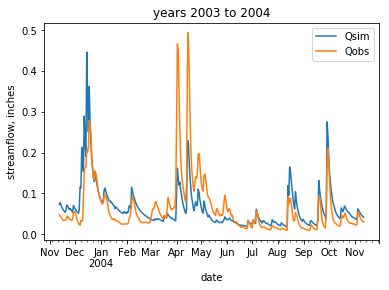

In [142]:
Qsim_2003.plot()
Qobs_2003.plot()
plt.legend()
plt.ylabel('streamflow, inches')
plt.title('years 2003 to 2004')

In [143]:
LQsim_2003=Q_P['LQsim'].loc['11-12-2003':'11-12-2004']
LQobs_2003=Q_P['LQobs'].loc['11-12-2003':'11-12-2004']

Text(0.5,1,'years 2003 to 2004')

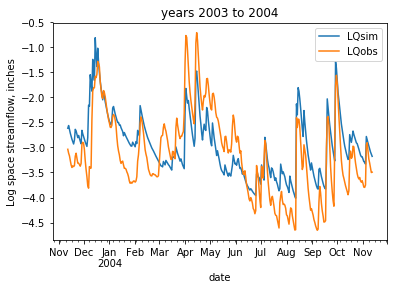

In [144]:
LQsim_2003.plot()
LQobs_2003.plot()
plt.legend()
plt.ylabel('Log space streamflow, inches')
plt.title('years 2003 to 2004')

In [145]:
Ground=ground.tolist()
Soil=soil.tolist()
Q_P['Ground']=Ground
Q_P['Soil']=Soil

In [146]:
Ground_2003=Q_P['Ground'].loc['11-12-2003':'11-12-2004']
Soil_2003=Q_P['Soil'].loc['11-12-2003':'11-12-2004']

Text(0.5,1,'years 2005 to 2006')

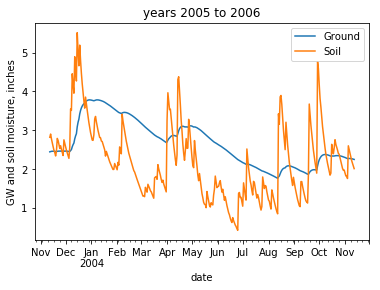

In [147]:
Ground_2003.plot()
Soil_2003.plot()
plt.legend()
plt.ylabel('GW and soil moisture, inches')
plt.title('years 2005 to 2006')

# Validation

In [148]:
Precip=SnowMelt(precip_val,Tmax_val,res.x[4],res.x[5],Julian_date,Tb,res.x[6])
Qs,ys,ground,soil=ABCD(Precip,PE_val,res.x[0:4])

In [149]:
validation_LBEm=LBEm(Qs,Q_obs_val,Month_vector[4064:],prime=False)
#LBEm(S,O,period,prime=False)
print('validation LBEm=',validation_LBEm)
validation_NSE=NSE(Qs,Q_obs_val)
print('validation NSE=',validation_NSE)
validation_LNSE=NSE(LN3_trans(Qs)[0],LN3_trans(Q_obs_val)[0])
print('validation LNSE=',validation_LNSE)

validation LBEm= 0.427118697521035
validation NSE= 0.38147830355362533
validation LNSE= 0.5420587851388821


In [150]:
Qsim_2018=Q_P['Qsim'].loc['11-12-2018':'11-12-2019']
Qobs_2018=Q_P['Qobs'].loc['11-12-2018':'11-12-2019']

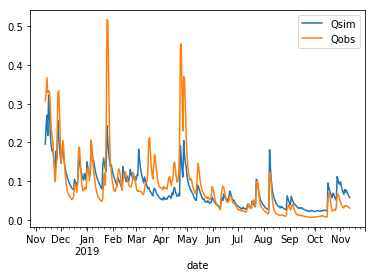

In [151]:
Qsim_2018.plot()
Qobs_2018.plot()
plt.legend()

In [152]:
LQsim_2018=Q_P['LQsim'].loc['11-12-2018':'11-12-2019']
LQobs_2018=Q_P['LQobs'].loc['11-12-2018':'11-12-2019']

Text(0.5,1,'years 2018 to 2019')

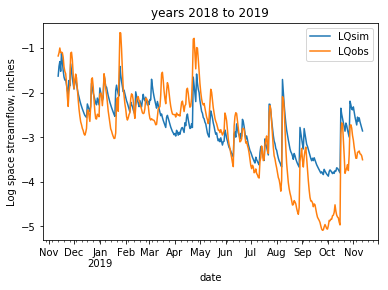

In [153]:
LQsim_2018.plot()
LQobs_2018.plot()
plt.legend()
plt.ylabel('Log space streamflow, inches')
plt.title('years 2018 to 2019')